# Table of Contents


[Definition of Utility Functions](#util_func) <br/>
[Faster R-CNN Implementation](#fasterRCNN): <br/>
- [Baseline Implementation](#fasterRCNN_baseline) <br/>
- [Custom anchor sizes](#custom_anchor) <br/>

<br/><br/>
[YOLOv11 Implementation](#YOLOv11): <br/>


remember: First Bullet Header <a class="anchor" name="first-bullet"></a>

In [1]:
#set up github

Cloning into 'Object-Detection-Neural-Networks'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 27 (delta 10), reused 15 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 8.46 MiB | 30.60 MiB/s, done.
Resolving deltas: 100% (10/10), done.


## Definition of Utility Functions: <a class="anchor" name="util_func"></a>

In [5]:
import shutil

# !git pull
# !git status

#check remotes
#!git remote -v


def git_push(message, branch):
  #move to git repo before using git commands
  %cd '/content/Object-Detection-Neural-Networks'

  #copy current notebook to cloned git repo
  file_to_copy = '/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test/UoL Final Project based on CM3015 template "deep learning on public dataset".ipynb'
  git_repo = '/content/Object-Detection-Neural-Networks'

  #overwrite the file in the local cloned github repo
  shutil.copy(file_to_copy, git_repo)

  !git add 'UoL Final Project based on CM3015 template "deep learning on public dataset".ipynb'

  !git commit -a -m "{message}"
  !git push origin "{branch}"

def publish_branch(branch):
  %cd '/content/Object-Detection-Neural-Networks'
  !git push -u origin "{branch}"

def create_branch(branch):
  %cd '/content/Object-Detection-Neural-Networks'
  !git checkout -b "{branch}"

In [2]:
%cd '/content/Object-Detection-Neural-Networks'
!git branch

/content/Object-Detection-Neural-Networks
* main


In [3]:
#CURRENT BRANCH
%cd '/content/Object-Detection-Neural-Networks'
!git switch "training_func"

/content/Object-Detection-Neural-Networks
Branch 'training_func' set up to track remote branch 'training_func' from 'origin'.
Switched to a new branch 'training_func'


In [4]:
git_push("Add Docstrings for function 'visualisePredictions' and class UAVImageDataset", "training_func")

NameError: name 'git_push' is not defined

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

def visualisePredictions(img_id: int,
                         test_dataset: torch.utils.data.dataset.Subset,
                         predicted: list) -> None:

  """Visualises model predictions (bounding boxes) on top of the corresponding image

    Retrieves the original image from the test set and plots bouning boxes onto the image.
    Each classes is represented by a different colour bounding box.

    Args:
        img_id: the number of the image within the batch,

        test_dataset: Subset of PyTorch dataset ; each item in the array is a tuple consisting of
        a tensor representing the image and a dictionary containing 'boxes' and 'labels' keys,

        precicted: array of model predictions for set of images ; the array consists of
        dictionaries each with 2 keys: boxes and labels

    Returns:
        No value returned ; only plt.show()

    Raises:
        IndexError: An error occurred accessing the image at the specified index.
    """

  try:
    img = test_dataset[img_id][0].permute(1,2,0)
    predictions = predicted[img_id]

    fig, ax = plt.subplots()
    ax.imshow(img)

    for (index, box) in enumerate(predictions['boxes']):
      #move data from GPU to CPU ready for visualisation
      cpu_box = box.cpu()
      predicted_label = predictions['labels'][index]

      #class names: ['migrating_single', 'plastic', 'water_hyacinth']
      colour_mappings = ['y', 'white', 'orange']
      #draw bounding box
      try:
        bbox = patches.Rectangle((cpu_box[0], cpu_box[1]), cpu_box[2], cpu_box[3], linewidth=1, edgecolor=colour_mappings[predicted_label], facecolor='none')
      except IndexError:
        print("Bounding box does not have 4 coordinates")
        print(cpu_box)
        raise

      # Add the patch to the Axes
      ax.add_patch(bbox)
    plt.show()

  except IndexError:
      print(f'Provided dataset is of length {len(test_dataset)} - image index {img_id} not within range')
      raise


## Faster R-CNN Implementation: <a class="anchor" name="fasterRCNN"></a>

### Base line Implementation: <a class="anchor" name="fasterRCNN_baseline"></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
root_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train'
image_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train/images'
label_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train/labels'

In [9]:
import os
import torch
import torchvision
from torchvision import transforms

from PIL import Image
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

In [10]:
import random
import numpy as np

#print(torch.__version__)
device = torch.device("cuda:0")
print(device)

#the google style guide suggest that a docstring is not necessary for the set_seeds() function
#as it does not meet any of the following critera
#A docstring is mandatory for every function that has one or more of the following properties:
  # - being part of the public API
  # - nontrivial size
  # - non-obvious logic
#https://github.com/google/styleguide/blob/gh-pages/pyguide.md#38-comments-and-docstrings

#THE SET_SEEDS FUNCTION IS SOURCED FROM:
#https://learnopencv.com/fine-tuning-faster-r-cnn/#aioseo-code-walkthrough
def set_seeds():
  # fix random seeds
  SEED_VALUE = 42
  random.seed(SEED_VALUE)
  np.random. seed(SEED_VALUE)
  torch.manual_seed(SEED_VALUE)
  if torch.cuda.is_available:
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seeds()

cuda:0


In [11]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class UAVImageDataset(Dataset):
    """Overrides the PyTorch Dataset class

      Defines how raw data should be read and transformed ready for model training

      Attributes:
          data_dir_imgs: file string path to raw images
          data_dir_targets: file string path to raw target data
          imgs: the formatted images ready for training
          targets: the formatted targets ready for training
    """

    def __init__(self, data_dir_imgs: str, data_dir_targets: str, transform=None) -> None:
        """Formats the raw images and targets ready for model training

          Images are converted to tensors as required by PyTorch for model training
          All tensor representations of images are stored in a List
          Targets (boxes and labels) are compiled into a dictionary for each image
          All targets are stored in a list
          An image and it's targets are stored at the same index in their respective arrays

        Args:
          data_dir_imgs: a string representing the file path to the image folder of the dataset
          data_dir_targets: a string representing the file path to the 'targets' folder of the dataset
        """

        self.data_dir_imgs = data_dir_imgs
        self.data_dir_targets = data_dir_targets
        self.transforms = transforms

        file_names = os.listdir(path=data_dir_imgs)
        number_of_images = len(file_names)

        self.imgs = []
        self.targets = []

        for i in range(number_of_images):
            img = data_dir_imgs + '/'+ file_names[i]
            img_read = cv2.imread(img)
            image_transform = transforms.ToTensor()  #cv library reads as a numpy array, needs to be a pytorch tensor to be compatible
            img = image_transform(img_read)
            self.imgs.append(img)

            #remove .jpg or .png file extension and retrieve corresponding labels
            with open(data_dir_targets + '/' + file_names[i][:-4]+ '.txt','r') as f:
                file_lines = f.read().splitlines()

                targets = {
                        "boxes": [],
                        "labels": []
                    }

                #.txt label files with no annotations cause training error;
                if len(file_lines) ==0:
                    #follow 2 lines of code sourced from:
                    #https://discuss.pytorch.org/t/fasterrcnn-images-with-no-objects-present-cause-an-error/117974/13
                    #to address the issue of images with no ground truth bounding boxes
                    targets["boxes"] = torch.as_tensor(np.array(np.zeros((0, 4)), dtype=float))
                    targets["labels"] = torch.as_tensor(np.array([], dtype=int), dtype=torch.int64)
                else:
                    for file_line in file_lines:
                        indiv_items = file_line.split(" ")
                        label, x1, y1, width, height = indiv_items[0], indiv_items[1], indiv_items[2], indiv_items[3], indiv_items[4]
                        label = int(label)
                        x1, width,  = float(x1)*img_read.shape[1], float(width)*img_read.shape[1],
                        y1, height = float(y1)*img_read.shape[0], float(height)*img_read.shape[0]
                        x2 = x1 + width
                        y2 = y1 + height

                        #ADD TRY EXCEPT CLAUSE HERE
                        if x2 < x1 or x1 == x2 or y2 < y1 or y1 == y2:
                            print('Invalid Ground Truth Bounding Box')
                            print(x1, y1, x2, y2)

                        #YOLO label format is x-centre, y-centre, width, height
                        targets['boxes'].append([x1-width/2, y1-height/2, x2-width/2, y2-height/2])
                        targets['labels'].append(label)

                self.targets.append(targets)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx], self.targets[idx]

In [12]:
dataset = UAVImageDataset(data_dir_imgs=image_folder_path, data_dir_targets=label_folder_path)

In [13]:
from torch.utils.data import random_split

#ADD VALIDATION SET HERE - MULTIPLE VALIDATION SETS ?
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

In [14]:
#set shuffle to True so that the training of the model is not dependent on the order of the data
#only have shuffle=False for validation/testing and inference
train_dataset = torch.utils.data.DataLoader(train_dataset, collate_fn=lambda x: x, batch_size=16, shuffle=True)

In [15]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #- 0.1568 mAP50
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True) - 0.1080 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True) - 0.0434 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True) - 0.0161 mAP50

#needs separate fine tuning process for this model
#model = torchvision.models.detection.ssd300_vgg16(pretrained=True)


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

num_classes = 4  #+1 for background - there are 3 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 176MB/s]


In [16]:
optimizer = torch.optim.SGD(model.parameters() , lr=0.0005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)
num_epochs = 15

In [17]:
import numpy as np

#as a utility function to ensure each iteration of Faster R-CNN is trained in the same way
#ie keep the training procedure as a control

#CONTINUE WATCHING THIS VIDEO
#https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
def train_model(num_epochs, train_dataset, model, optimizer):

  for epoch in range(num_epochs):
      for batch in train_dataset:
          images = []
          targets = []

          for img, targets_dict in batch:
              images.append(img)


              #target boxes expected to be of type Tensor
              targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])
              #format to tensor of dtype float 32 as supported by MPS
              targets_dict['boxes'] = targets_dict['boxes'].type(torch.float32)

              targets_dict['labels'] = torch.tensor(targets_dict['labels'])
              targets_dict['labels'] = targets_dict['labels'].type(torch.int64)


              targets.append(targets_dict)


          #move relevant data to GPU
          #otherwise error: RuntimeError: Mismatched Tensor types in NNPack convolutionOutput
          model.to(device)
          images = [ t.to(device) for t in images]
          targets = [ {'boxes':d['boxes'].to(device), 'labels':d['labels'].to(device)} for d in targets]

          loss_dict = model(images, targets)
          loss = sum(v for v in loss_dict.values())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          print(loss)

          #memory management
          # images = [ t.cpu() for t in images]
          # targets = [ {'boxes':d['boxes'].cpu(), 'labels':d['labels'].cpu()} for d in targets]
          # del images
          # del targets

In [18]:
train_model(num_epochs, train_dataset, model, optimizer)

<ipython-input-17-1106b859d536>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])
<ipython-input-17-1106b859d536>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['labels'] = torch.tensor(targets_dict['labels'])


tensor(3.5076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.7968, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2330, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8503, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7283, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4176, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1281, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1442, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1496, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7580, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8618, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9482, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1129, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2696, device='cuda:0', grad_fn=<AddBack

In [19]:
#evaluate on test set - only give image to model
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, collate_fn=lambda x: x, batch_size=16)

In [21]:
torch.cuda.empty_cache()

images = []
targets = []
for batch in test_dataset_loader:
    for img, targets_dict in batch:
        #img = img.to(device)
        images.append(img)


        #format to tensor of dtype float 32 as supported by MPS
        targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])
        targets_dict['boxes'] = targets_dict['boxes'].type(torch.float32)
        #targets_dict['boxes'] =targets_dict['boxes'].to(device)

        targets_dict['labels'] = torch.tensor(targets_dict['labels'])
        targets_dict['labels'] = targets_dict['labels'].type(torch.int64)
        #targets_dict['labels'] =targets_dict['labels'].to(device)


        targets.append(targets_dict)

images = [ t.to(device) for t in images]
targets = [ {'boxes':d['boxes'].to(device), 'labels':d['labels'].to(device)} for d in targets]

#reduce memory usage by not storing intermediate tensors needed to calculate gradients
#torch.no_grad reportedly speeds up computations
with torch.no_grad():
  predicted = model(images)

<ipython-input-21-1544ebd6cce4>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])
<ipython-input-21-1544ebd6cce4>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['labels'] = torch.tensor(targets_dict['labels'])


In [22]:
!pip install torchmetrics
!pip install faster-coco-eval
!pip install pycocotools
#https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html

from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5, 0.75], class_metrics=True)

for pred in predicted:
    indices_to_keep = torchvision.ops.nms(pred['boxes'], pred['scores'], 0.8)
    #print(len(pred['boxes']))
    #print(indices_to_keep)
    pred = {
        'boxes': pred['boxes'][indices_to_keep],
        'labels': pred['labels'][indices_to_keep],
        'scores': pred['scores'][indices_to_keep],
    }
    #print(len(pred['boxes']))

# Update metric with predictions and respective ground truth
metric.update(predicted, targets)

# Compute the results
result = metric.compute()
print(result)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.9/470.9 kB 28.0 MB/s eta 0:00:00
{'map': tensor(0.3355), 'map_50': tensor(0.3754), 'map_75': tensor(0.2957), 'map_small': tensor(0.1118), 'map_medium': tensor(0.2491), 'map_large': tensor(0.3005), 'mar_1': tensor(0.0898), 'mar_10': tensor(0.3367), 'mar_100': tensor(0.4405), 'mar_small': tensor(0.1875), 'mar_medium': tensor(0.4711), 'mar_large': tensor(0.3762), 'map_per_class': tensor([0.0000, 0.2099, 0.7967]), 'mar_100_per_class': tensor([0.0000, 0.4028, 0.9187]), 'classes': tensor([0, 1, 2], dtype=torch.int32)}


In [23]:
print('mAP50:')
print(result['map_50'])

print('mAP75:')
print(result['map_75'])

mAP50:
tensor(0.3754)
mAP75:
tensor(0.2957)


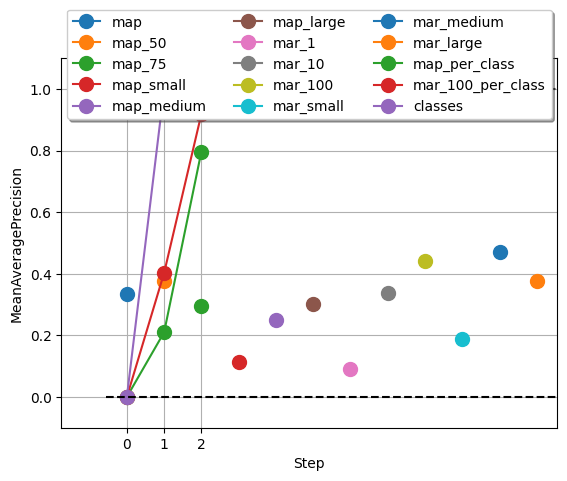

In [24]:
fig_, ax_ = metric.plot()

In [28]:
for i in range(len(predicted)):
  visualisePredictions(i, test_dataset, predicted)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
-stop execution-

SyntaxError: invalid syntax (<ipython-input-26-e25be53e5bad>, line 1)

### Custom Anchor sizes: <a class="anchor" name="custom_anchor"></a>

In [ ]:
#**********************************NEW

# frame of reference
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator

# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(
#     sizes=((32, 64, 128, 256, 512),),
#     aspect_ratios=((0.5, 1.0, 2.0),)
# )

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2
# )

# # put the pieces together inside a Faster-RCNN model
# model = FasterRCNN(
#     backbone,
#     num_classes=2,
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# )

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn

#work around: AttributeError: 'ResNet' object has no attribute 'features'
# backbone = torchvision.models.resnet50(weights="DEFAULT").features
# #https://discuss.pytorch.org/t/change-resnet50s-number-of-output-filters/146644
# backbone.out_channels = 2048

# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

resnet_net = torchvision.models.resnet50(pretrained=True)
modules = list(resnet_net.children())[:-2]
backbone = nn.Sequential(*modules)
backbone.out_channels = 2048

#default
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
anchor_ars = ((0.5, 1.0, 2.0),) * len (anchor_sizes)

anchor_generator = AnchorGenerator(
    sizes=anchor_sizes,
    aspect_ratios=anchor_ars
)
# sizes=((16, 32, 64, 128, 256),),
#     aspect_ratios=((0.5, 1.0, 2.0),)


# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2)

#keep default
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"],
                                                output_size=7,
                                                sampling_ratio=2)


model = FasterRCNN(
    backbone,
    num_classes=4,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [ ]:
optimizer = torch.optim.SGD(model.parameters() , lr=0.0005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)
num_epochs = 20

## YOLOv11 Implementation: <a class="anchor" name="YOLOv11"></a>

In [ ]:
!pip install ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from ultralytics import YOLO

In [ ]:
import numpy as np
import random
import torch
#THE SET_SEEDS FUNCTION IS SOURCED FROM:
#https://learnopencv.com/fine-tuning-faster-r-cnn/#aioseo-code-walkthrough
def set_seeds():
  # fix random seeds
  SEED_VALUE = 42
  random.seed(SEED_VALUE)
  np.random. seed(SEED_VALUE)
  torch.manual_seed(SEED_VALUE)
  if torch.cuda.is_available:
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seeds()

In [ ]:
# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/YOLO_11_w_project_data_second/data.yaml", # path to dataset YAML
    epochs=15, # number of training epochs
    imgsz=640, # training image size
    ) # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu